In [1]:
import os
import shutil
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

import numpy as np
import math

plt.rcParams["font.size"] = 25
plt.rcParams['font.sans-serif'] = ['Arial']


In [2]:
############################################################ Read data for file_types
# fileの分岐を確認
file_types = ['Chem.CSV', 'Param.CSV', 'Goal.CSV'] # Path_Df[5].unique() 

path_untill_2 = '../0_Data/1_Rietveld/'
Path_List = glob.glob(path_untill_2+"*/*/*.CSV")
Path_Df = pd.DataFrame([path.split("/") for path in Path_List])

# display(Path_List)
"""
データの中身
'Chem.CSV'   ['File', 'Sample', 'Sample ID', 'Phase', 'Phase Quantity', 'Oxide','Quantity (wt-%)']
'Param.CSV'  
['File', 'Sample', 'Sample ID', 'Phase', 'Refined Composition', 'A',
       'ESD(A)', 'B', 'ESD(B)', 'C', 'ESD(C)', 'ALPHA', 'ESD(ALPHA)', 'BETA',
       'ESD(BETA)', 'GAMMA', 'ESD(GAMMA)', 'GrainSize(1,1,1)',
       'ESD(GrainSize(1,1,1))']

'Goal.CSV'   ['File', 'Sample', 'Sample ID', 'Parameter, Goal', 'Value', 'ESD']
"""

rock_type = Path_Df[4].unique() # ['Pelitic', 'Mafic']
instrument_type = Path_Df[3].unique() # ['Laboratory', 'SPring-8']

# Compile df
Chem_df = pd.DataFrame()
Param_df = pd.DataFrame()
Goal_df = pd.DataFrame()
df_list = [Chem_df, Param_df, Goal_df]

'''
# File read
for path_0 in Path_Df[0].unique():
    for path_1 in Path_Df[1].unique():
        for path_2 in Path_Df[2].unique(): 
            # ここまでは同じ分岐
'''

# Chem.CSV compile
file_type='Chem.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        try: # Profexのversion変更による修正 ver 251113
            data_read["Phase Quantity"] = data_read["Phase Quantity (wt-%)"].copy()
            data_read["Phase"] = data_read["Phase"].replace("Weighted Total", "Weighted total") # この修正で貴重な２h使った。悔しい。
            print(path_csv)
        except:
            pass

        ######### Dataのread、整理
        Chem_df = pd.concat([data_read, Chem_df]) 
        ######### Dataのread、整理
        Chem_df = pd.concat([data_read, Chem_df]) 

# 'Param.CSV' compile
file_type='Param.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        ######### Dataのread、整理
        Param_df = pd.concat([data_read, Param_df]) 

# Goal.CSV compile
file_type='Goal.CSV'
for path_3 in Path_Df[3].unique(): # ['Laboratory', 'SPring-8']
    for path_4 in Path_Df[4].unique(): # ['Pelitic', 'Mafic']
        # Pathの記録
        path_csv = path_untill_2+"/"+path_3+"/"+path_4+"/"+file_type

        ######### Dataのread、整理
        data_read = pd.read_csv(path_csv, sep=';')
        data_read["Instrument"] = path_3 # Instrument typeを記録
        data_read["Rock_Type"] = path_4 # Instrument typeを記録
        ######### Dataのread、整理
        Goal_df = pd.concat([data_read, Goal_df]) 
############################################################ Read data for file_types


../0_Data/1_Rietveld//Laboratory/Mafic/Chem.CSV


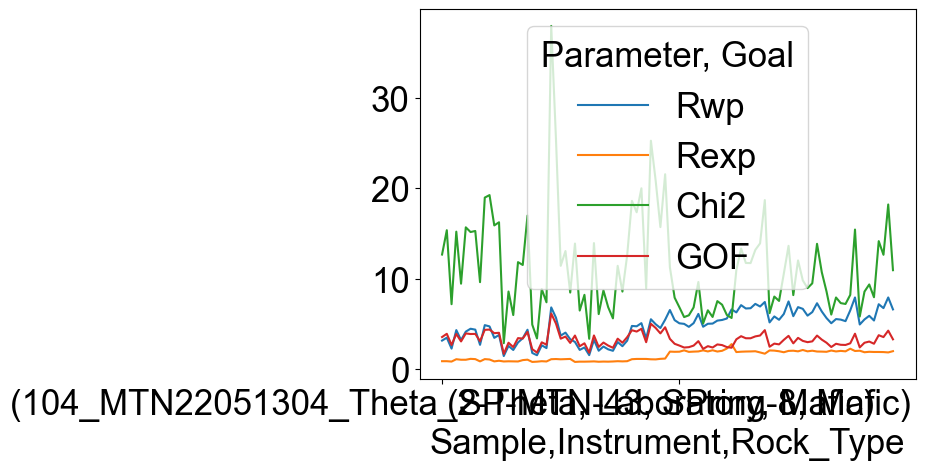

In [3]:
# Chem
############################################################ Bulk chemical composition compile
pivot_chem_df = Chem_df.pivot_table(index=['Sample', "Instrument", "Rock_Type", "Phase", "Phase Quantity"], columns='Oxide', values='Quantity (wt-%)') # compile mode
pivot_bulk_comp_df = pivot_chem_df.loc[pivot_chem_df.index.get_level_values("Phase") == "Weighted total"]
############################################################ Bulk chemical composition compile

# Param
############################################################ Compile Mineral Parameter
important_param_sample = ['Sample', "Instrument", "Rock_Type", "Phase",]
important_param_value = ['A','B','C','ALPHA','BETA','GAMMA'] # 結晶の情報をコンパイル

Param_compile_df = Param_df[important_param_sample+important_param_value] #.fillna(0)
############################################################ Compile Mineral Parameter

# Goal
############################################################ Bulk mode compile
pivot_bulk_mode_df = Goal_df.pivot_table(index=['Sample', "Instrument", "Rock_Type"], columns='Parameter, Goal', values='Value') # compile mode
pivot_bulk_mode_df = pivot_bulk_mode_df.fillna(0)

# 誤差の可視化
# 誤差リスト
error_col = ['Rwp', 'Rexp', 'Chi2', 'GOF']
pivot_error_df = pivot_bulk_mode_df[error_col]
pivot_error_df.plot()

# Not need for mode['Rwp', 'Rexp', 'Chi2', 'GOF']
pivot_bulk_mode_df = pivot_bulk_mode_df.drop(['Rwp', 'Rexp', 'Chi2', 'GOF'], axis=1).fillna(0)
############################################################ Bulk mode compile

#filtered_df = pivot_bulk_mode_df.loc[pivot_bulk_mode_df.index.get_level_values('Instrument') == instrument_name]


# Output df
folder_path = "../0_Data/2_Compiled_Data/"
pivot_chem_df.to_excel(folder_path+"pivot_chem_df.xlsx")
pivot_bulk_comp_df.to_excel(folder_path+"pivot_bulk_comp_df.xlsx")
Param_compile_df.to_excel(folder_path+"Param_compile_df.xlsx")
pivot_error_df.to_excel(folder_path+"pivot_error_df.xlsx")
pivot_bulk_mode_df.to_excel(folder_path+"pivot_bulk_mode_df.xlsx")


<Axes: xlabel='Sample,Instrument,Rock_Type'>

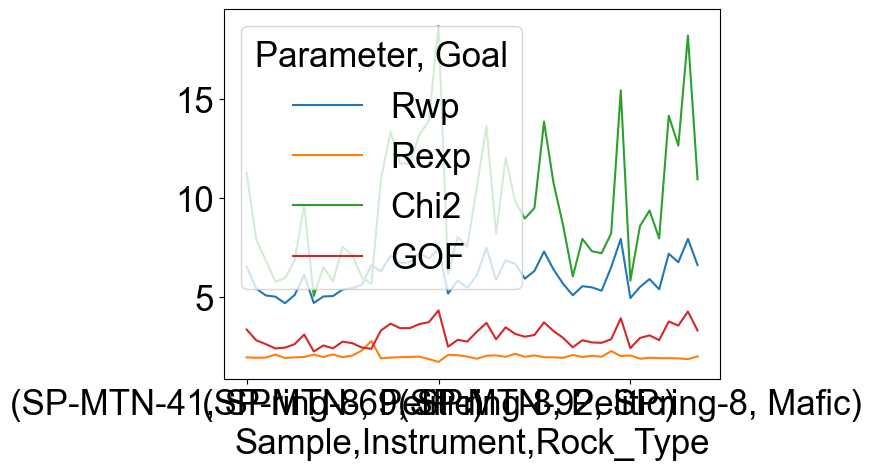

In [4]:
pivot_error_df.loc[pivot_error_df.index.get_level_values('Instrument') == "SPring-8"].plot()


<Axes: xlabel='Sample,Instrument,Rock_Type'>

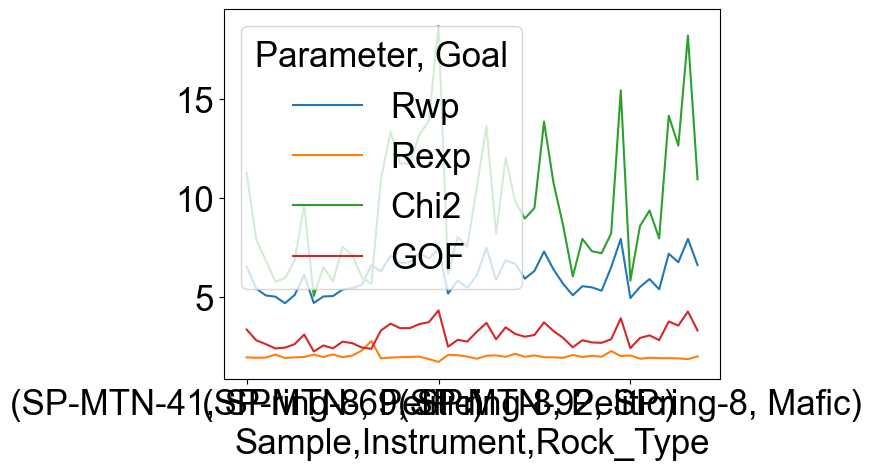

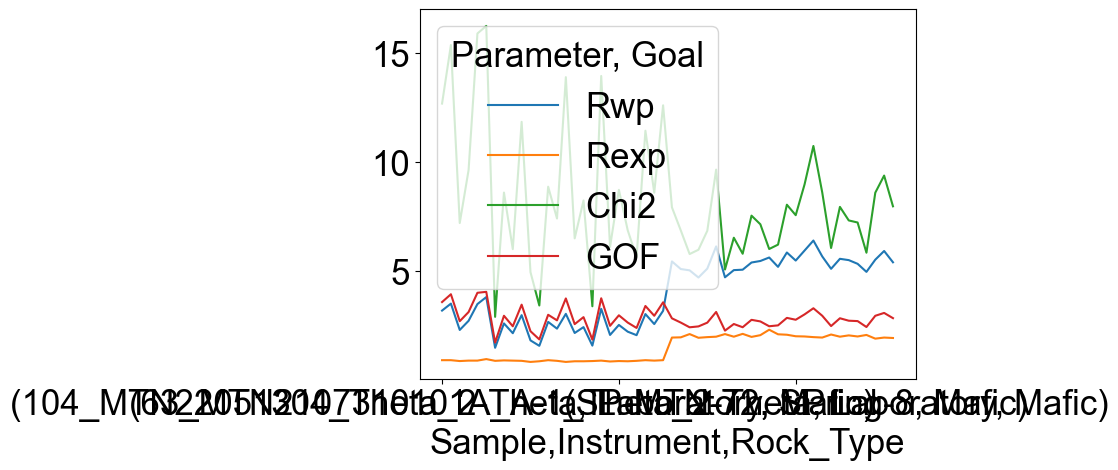

In [5]:
pivot_error_df.loc[pivot_error_df.index.get_level_values('Instrument') == "SPring-8"].plot()
pivot_error_df.loc[pivot_error_df.index.get_level_values('Rock_Type') == "Mafic"].plot()


In [6]:
pivot_bulk_comp_df


,,,,Oxide,Al2O3,CO2,CaO,Cl,F,Fe2O3,H2O,K2O,MgO,MnO,Na2O,P2O5,SO3,SiO2,TiO2
Sample,Instrument,Rock_Type,Phase,Phase Quantity,,,,,,,,,,,,,,,
104_MTN22051304_Theta_2-Theta,Laboratory,Mafic,Weighted total,100.0000,17.62,2.19,11.32,0.02,0.13,10.56,1.98,1.10,4.72,0.0,2.85,0.24,NaN,45.10,2.18
105_MTN22051305_Theta_2-Theta,Laboratory,Mafic,Weighted total,100.0000,18.78,1.94,9.73,0.01,0.08,12.72,2.59,0.81,4.15,0.0,3.21,0.23,NaN,44.58,1.17
106_MTN22051306_Theta_2-Theta,Laboratory,Mafic,Weighted total,100.0000,19.00,0.58,11.03,0.02,0.11,11.94,2.44,0.72,5.51,0.0,2.24,0.00,NaN,44.71,1.72
107_MTN22051307_Theta_2-Theta,Laboratory,Pelitic,Weighted total,1.0001,18.51,NaN,0.46,NaN,NaN,5.04,1.49,1.76,2.09,NaN,4.29,NaN,NaN,65.73,0.65
108_MTN22051308_Theta_2-Theta,Laboratory,Pelitic,Weighted total,1.0000,20.90,NaN,0.53,NaN,NaN,6.22,2.32,3.45,3.48,NaN,1.77,NaN,NaN,60.57,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SP-MTN-95,SPring-8,Mafic,Weighted total,0.9999,15.98,2.12,13.61,0.02,0.16,13.33,2.20,0.49,4.76,0.0,1.87,0.26,NaN,43.55,1.64
SP-MTN-96,SPring-8,Pelitic,Weighted total,1.0000,14.22,0.00,0.64,NaN,0.01,3.70,0.71,2.40,0.43,NaN,2.62,0.07,NaN,74.68,0.52
SP-MTN-97,SPring-8,Pelitic,Weighted total,1.0000,14.73,0.12,0.73,NaN,0.01,2.67,0.59,2.31,0.57,NaN,3.47,0.10,NaN,74.16,0.54
